In [1]:
!pip install d2l

In [2]:
pip install --upgrade torchvision torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
torch.__version__

'2.4.1'

In [4]:
import d2l_common
import d2l

In [5]:
d2l_common.DATA_URL

'http://d2l-data.s3-accelerate.amazonaws.com/'

In [6]:
file = d2l_common.download_extract(d2l_common.DATA_URL+'aclImdb_v1.tar.gz', '../data')

In [7]:
import os
#@save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels


In [8]:
data_dir = '../data/aclImdb'
# Read training data
train_data, train_labels = read_imdb(data_dir, is_train=True)

# Read testing data
test_data, test_labels = read_imdb(data_dir, is_train=False)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

Number of training samples: 25000
Number of testing samples: 25000


In [9]:
print('# train:', len(train_data))
for x, y in zip(train_data[:3], train_labels[:3]):
    print('label:', y, 'review:', x[:60])

# train: 25000
label: 1 review: For a movie that gets no respect there sure are a lot of mem
label: 1 review: Bizarre horror movie filled with famous faces but stolen by 
label: 1 review: A solid, if unremarkable film. Matthau, as Einstein, was won


In [38]:
import d2l_common

train_tokens = d2l_common.tokenize(train_data, token='word')
# for i in range(2):
#     print(train_tokens[0])
# train_tokens[:1]
print(len(train_tokens))
train_tokens[:6]

25000


[['For',
  'a',
  'movie',
  'that',
  'gets',
  'no',
  'respect',
  'there',
  'sure',
  'are',
  'a',
  'lot',
  'of',
  'memorable',
  'quotes',
  'listed',
  'for',
  'this',
  'gem.',
  'Imagine',
  'a',
  'movie',
  'where',
  'Joe',
  'Piscopo',
  'is',
  'actually',
  'funny!',
  'Maureen',
  'Stapleton',
  'is',
  'a',
  'scene',
  'stealer.',
  'The',
  'Moroni',
  'character',
  'is',
  'an',
  'absolute',
  'scream.',
  'Watch',
  'for',
  'Alan',
  '"The',
  'Skipper"',
  'Hale',
  'jr.',
  'as',
  'a',
  'police',
  'Sgt.'],
 ['Bizarre',
  'horror',
  'movie',
  'filled',
  'with',
  'famous',
  'faces',
  'but',
  'stolen',
  'by',
  'Cristina',
  'Raines',
  '(later',
  'of',
  "TV's",
  '"Flamingo',
  'Road")',
  'as',
  'a',
  'pretty',
  'but',
  'somewhat',
  'unstable',
  'model',
  'with',
  'a',
  'gummy',
  'smile',
  'who',
  'is',
  'slated',
  'to',
  'pay',
  'for',
  'her',
  'attempted',
  'suicides',
  'by',
  'guarding',
  'the',
  'Gateway',
  'to',
  

In [41]:
import d2l_common

vocab = d2l_common.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
len(vocab)

49347

In [42]:
import matplotlib.pyplot as plt

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650., 700., 750., 800., 850., 900., 950.]),
 <BarContainer object of 19 artists>)

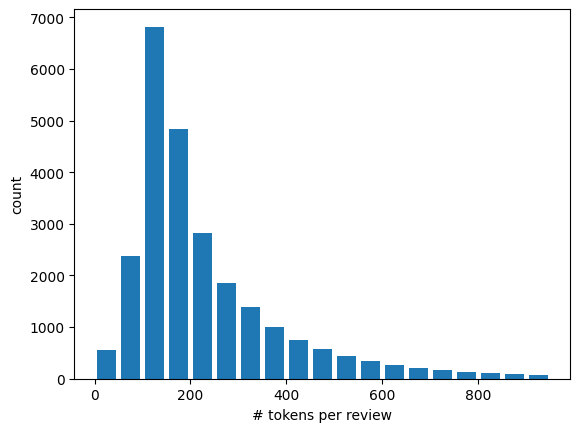

In [43]:
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50), rwidth=0.8)

In [47]:
num_steps = 500 # Sequence length
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
train_features.shape

torch.Size([25000, 500])

In [49]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

train_iter = load_array((train_features, torch.tensor(train_labels)), 64)
for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [50]:
def load_data_imdb(batch_size, num_steps=500):
    data_dir = d2l_common.download_extract('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    train_data, test_data = read_imdb(data_dir, is_train=True)
    train_tokens = d2l_common.tokenize(train_data, token='word')
    test_tokens = d2l_common.tokenize(test_data, token='word')
    vocab = d2l_common.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_labels)), batch_size)
    test_iter = load_array((test_features, torch.tensor(test_labels)), batch_size, is_train=False)
    return train_iter, test_iter, vocab

In [ ]:
load_data_imdb(64, 500)